In [1]:
import os 
os.chdir(r'C:\Users\braya\Documents\github\colibri-hdsp')

Demo CASSI Reconstruction

In [2]:
#General imports
import matplotlib.pyplot as plt
import torch
import os


# Check GPU support
print("GPU support: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU support:  True


Load Dataset

In [3]:
from colibri_hdsp.data.datasets import Dataset

# Load dataset

dataset_path = 'cifar10'
keys = ''
batch_size = 128

dataset = Dataset(dataset_path, keys, batch_size)

Loading dataset:  cifar10
Files already downloaded and verified
Files already downloaded and verified


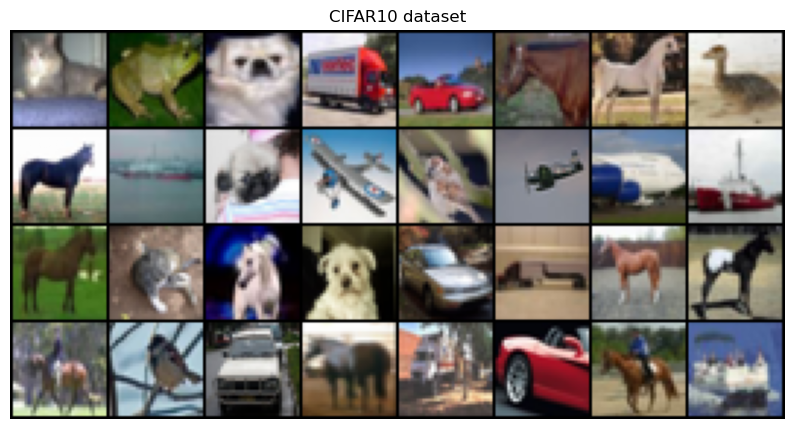

In [4]:
# import make_grid from torchvision
from torchvision.utils import make_grid

sample = next(iter(dataset.train_dataset))[0]

img = make_grid(sample[:32], nrow=8, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.title('CIFAR10 dataset')
plt.axis('off')
plt.show()

Optics Layer

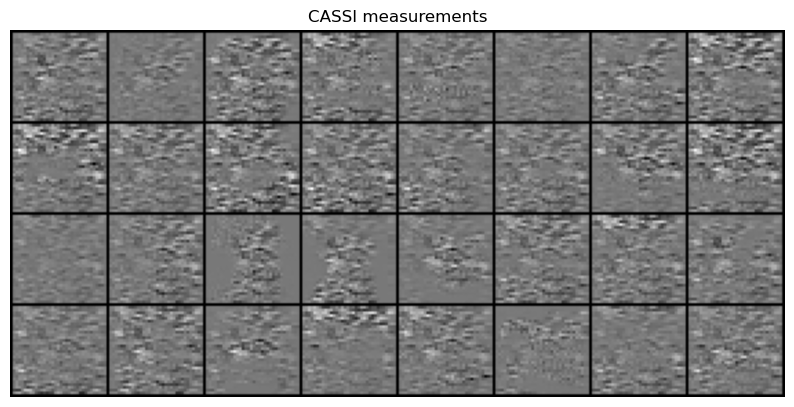

In [5]:
from colibri_hdsp.optics.cassi import CASSI

mode = 'base' # Type of CASSi optical system
cassi =  CASSI(sample.shape[1:], mode,  trainable=True) # CASSI layer
y = cassi(sample) # CASSI measurements

img = make_grid(y[:32], nrow=8, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)


plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title('CASSI measurements')
plt.show()

Build Model

In [6]:
import torch.nn as nn
from colibri_hdsp.models import build_network, Unet
from colibri_hdsp.archs import E2E


recovery_model = build_network(Unet, in_channels=cassi.L, out_channels=cassi.L)

model = E2E(cassi, recovery_model)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

Training Loop

In [7]:
from tqdm import tqdm
from torchmetrics import MeanMetric
from colibri_hdsp.metrics import psnr, ssim


epochs = 5

for epoch in range(epochs):

    loss_record = MeanMetric()
    psnr_record = MeanMetric()
    ssim_record = MeanMetric()

    with tqdm(total=len(dataset.train_dataset), dynamic_ncols=True, colour="blue") as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{epochs}")

        for batch_idx, (x, _) in enumerate(dataset.train_dataset):

            tq.update(1)

            optimizer.zero_grad()

            x = x.to(device)

            x_est   = model(x)

            loss = criterion(x, x_est)
            loss.backward()
            optimizer.step()

            loss     = loss.item()
            psnr_val = psnr(x, x_est).item()
            ssim_val = ssim(x, x_est).item()

            loss_record(loss)
            psnr_record(psnr_val)
            ssim_record(ssim_val)
            
            tq.set_postfix(s=f"Loss: {loss:.7f}, PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}")

    mean_loss = loss_record.compute().item()
    mean_psnr = psnr_record.compute().item()
    mean_ssim = ssim_record.compute().item()
    tq.set_postfix(s=f"Epoch Loss: {mean_loss:.7f}, PSNR: {mean_psnr:.2f}, SSIM: {mean_ssim:.4f}")
        



Train :: Epoch: 4/5: 100%|██████████| 391/391 [00:42<00:00,  9.18it/s, s=Loss: 0.0023844, PSNR: 26.23, SSIM: 0.8902]


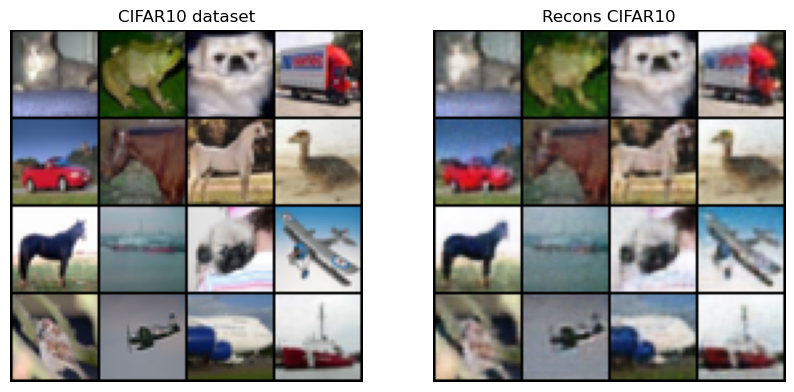

In [8]:
x_est = model(sample.to(device)).cpu()

img    = make_grid(sample[:16], nrow=4, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)
img_est = make_grid(x_est[:16], nrow=4, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title('CIFAR10 dataset')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_est.permute(1, 2, 0))
plt.title('Recons CIFAR10')
plt.axis('off')
plt.show()
